<a href="https://colab.research.google.com/github/Nisha40108/ParkNaviGo/blob/main/CNN_model_for_occupancy_KSU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
import os
import pandas as pd
import numpy
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as k
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

In [21]:


# Define the path to your images folder and labels CSV file
images_folder = '/content/drive/MyDrive/nisha/train_data/train/Image'
labels_csv = '/content/drive/MyDrive/nisha/train_data/train/labels.csv'  # Replace with the actual path

# Initialize variables to count the number of empty and occupied images
empty_count = 0
occupied_count = 0

# Initialize lists to store image filenames and labels
image_files = []
labels = []

# Iterate over subfolders in the main folder
for sub_folder in os.listdir(images_folder):
    sub_folder_path = os.path.join(images_folder, sub_folder)

    # Check if it's a directory
    if os.path.isdir(sub_folder_path):
        # Get the list of files in the subfolder
        files = os.listdir(sub_folder_path)

        # Update counts based on the number of files
        if "empty" in sub_folder:
            empty_count += len(files)
            label = "empty"
        elif "occupied" in sub_folder:
            occupied_count += len(files)
            label = "occupied"
        else:
            label = None  # or assign a different label for other cases

        # Append filenames and labels to the lists
        image_files.extend(files)
        labels.extend([label] * len(files))



In [22]:
# Verify counts
print("Number of empty images:", empty_count)
print("Number of occupied images:", occupied_count)

Number of empty images: 17
Number of occupied images: 8


In [24]:
# Create a DataFrame
data = {'Image': image_files, 'Label': labels}
df = pd.DataFrame(data)

# Print the DataFrame for verification
print(df.head(25))

# Save the DataFrame to the CSV file
df.to_csv(labels_csv, index=False)


            Image     Label
0      empty1.png     empty
1      empty2.png     empty
2     empty14.png     empty
3     empty13.png     empty
4     empty12.png     empty
5     empty11.png     empty
6     empty10.png     empty
7      empty9.png     empty
8      empty8.png     empty
9      empty6.png     empty
10     empty7.png     empty
11    empty15.png     empty
12    empty16.png     empty
13     empty5.png     empty
14     empty3.png     empty
15     empty4.png     empty
16     empty0.png     empty
17  occupied3.png  occupied
18  occupied7.png  occupied
19  occupied8.png  occupied
20  occupied1.png  occupied
21  occupied2.png  occupied
22  occupied4.png  occupied
23  occupied5.png  occupied
24  occupied6.png  occupied


### 1. Load Test and Train Files

In [8]:
files_validation = 0

cwd = os.getcwd()
folder = '/content/drive/MyDrive/nisha/train_data/test'
for sub_folder in os.listdir(folder):
    path, dirs, files = next(os.walk(os.path.join(folder,sub_folder)))
    files_validation += len(files)

print(files_train,files_validation)

25 8


### 2. Set key parameters

In [ ]:
img_width, img_height = 48, 48
train_data_dir = "/content/drive/MyDrive/nisha/train_data/train"
validation_data_dir = "/content/drive/MyDrive/nisha/train_data/test"
nb_train_samples = files_train
nb_validation_samples = files_validation
batch_size = 32
epochs = 15
num_classes = 2

### 3. Build model on top of a trained VGG

In [ ]:
model = applications.VGG16(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3))
# Freeze the layers which you don't want to train. Here I am freezing the first 5 layers.
for layer in model.layers[:10]:
    layer.trainable = False

In [ ]:
x = model.output
x = Flatten()(x)
# x = Dense(512, activation="relu")(x)
# x = Dropout(0.5)(x)
# x = Dense(256, activation="relu")(x)
# x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation="softmax")(x)

from keras.models import Model
# creating the final model
model_final = Model(inputs = model.input, outputs = predictions)

# compile the model
model_final.compile(loss = "categorical_crossentropy",
                    optimizer = optimizers.SGD(learning_rate=0.0001, momentum=0.9),
                    metrics=["accuracy"]) # See learning rate is very low

In [ ]:
# Initiate the train and test generators with data Augumentation
train_datagen = ImageDataGenerator(
rescale = 1./255,
horizontal_flip = True,
fill_mode = "nearest",
zoom_range = 0.1,
width_shift_range = 0.1,
height_shift_range=0.1,
rotation_range=5)

test_datagen = ImageDataGenerator(
rescale = 1./255,
horizontal_flip = True,
fill_mode = "nearest",
zoom_range = 0.1,
width_shift_range = 0.1,
height_shift_range=0.1,
rotation_range=5)

train_generator = train_datagen.flow_from_directory(
train_data_dir,
target_size = (img_height, img_width),
batch_size = batch_size,
class_mode = "categorical")

validation_generator = test_datagen.flow_from_directory(
validation_data_dir,
target_size = (img_height, img_width),
class_mode = "categorical")

Found 25 images belonging to 2 classes.
Found 8 images belonging to 2 classes.


In [ ]:
# Save the model according to the conditions
checkpoint = ModelCheckpoint("car1.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10, verbose=1, mode='auto')


In [ ]:
import os
from keras.callbacks import ModelCheckpoint, EarlyStopping
save_directory = '/content/drive/MyDrive/nisha'
checkpoint_filepath = os.path.join(save_directory, 'car1.h5')

In [ ]:
for batch in train_generator:
    break  # Break after the first batch to print information
print("Number of batches:", len(train_generator))
print("Number of samples in the first batch:", batch[0].shape)

# Set steps_per_epoch based on the number of batches in an epoch
steps_per_epoch = len(train_generator)

Number of batches: 1
Number of samples in the first batch: (25, 48, 48, 3)


In [ ]:
for batch in validation_generator:
    break  # Break after the first batch to print information
print("Number of batches:", len(train_generator))
print("Number of samples in the first batch:", batch[0].shape)

# Set steps_per_epoch based on the number of batches in an epoch
steps_per_epoch = len(train_generator)

Number of batches: 1
Number of samples in the first batch: (8, 48, 48, 3)


In [ ]:
history_object = model_final.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),  # Use the number of batches for validation
    callbacks=[checkpoint, early]
)


Epoch 1/15
1/1 [==============================] - ETA: 0s - loss: 0.9267 - accuracy: 0.3200
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to car1.h5
1/1 [==============================] - 5s 5s/step - loss: 0.9267 - accuracy: 0.3200 - val_loss: 0.7570 - val_accuracy: 0.5000
Epoch 2/15
1/1 [==============================] - ETA: 0s - loss: 0.8482 - accuracy: 0.3200
Epoch 2: val_accuracy did not improve from 0.50000
1/1 [==============================] - 2s 2s/step - loss: 0.8482 - accuracy: 0.3200 - val_loss: 0.6589 - val_accuracy: 0.5000
Epoch 3/15
1/1 [==============================] - ETA: 0s - loss: 0.7391 - accuracy: 0.3600
Epoch 3: val_accuracy improved from 0.50000 to 0.62500, saving model to car1.h5
1/1 [==============================] - 2s 2s/step - loss: 0.7391 - accuracy: 0.3600 - val_loss: 0.5881 - val_accuracy: 0.6250
Epoch 4/15
1/1 [==============================] - ETA: 0s - loss: 0.6985 - accuracy: 0.5200
Epoch 4: val_accuracy improved from 0.62500 to

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


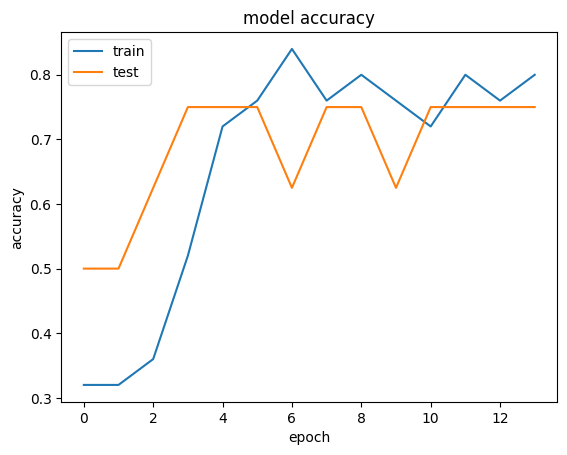

In [ ]:
import matplotlib.pyplot as plt
print(history_object.history.keys())
plt.plot(history_object.history['accuracy'])
plt.plot(history_object.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

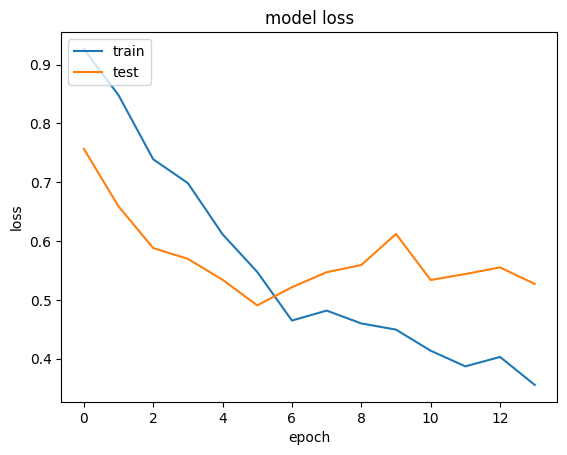

In [ ]:
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
from keras.models import load_model
test_model = load_model('car1.h5')
Model1_Results = test_model.evaluate(files_train)
print(f'Loss: {Model1_Results[0]:.3f}')
print(f'Accuracy: {Model1_Results[1]:.3f}')

ValueError: ignored